In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Current device is', device)

Current device is cpu


In [3]:
train_set = datasets.FashionMNIST('data/homework1/', 
                           download=True, 
                           train=True, 
                           transform=transforms.Compose([transforms.ToTensor()]))
test_set = datasets.FashionMNIST('data/homework1/', 
                          download=True, 
                          train=False, 
                          transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
print('Train data size: ', train_set.train_data.size())
print('Train data labels: ', train_set.train_labels.size())

print('Test data size: ', test_set.test_data.size())
print('Test data labels: ', test_set.test_labels.size())

Train data size:  torch.Size([60000, 28, 28])
Train data labels:  torch.Size([60000])
Test data size:  torch.Size([10000, 28, 28])
Test data labels:  torch.Size([10000])


/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [6]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [7]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [8]:
len(train_set)

60000

In [9]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

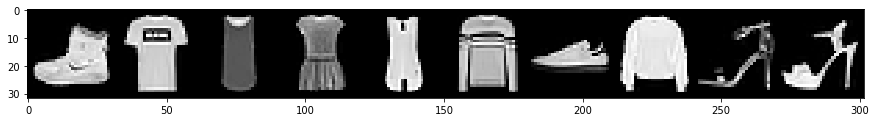

In [10]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [11]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc1 = nn.Linear(in_features=5 * 5 * 16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [12]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
num_epochs = 10
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 100):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 100, Loss: 2.297910690307617, Accuracy: 13%
Iteration: 200, Loss: 2.290733575820923, Accuracy: 14%
Iteration: 300, Loss: 2.212449312210083, Accuracy: 31%
Iteration: 400, Loss: 1.8993228673934937, Accuracy: 55%
Iteration: 500, Loss: 1.030419945716858, Accuracy: 60%
Iteration: 600, Loss: 0.9308953881263733, Accuracy: 64%
Iteration: 700, Loss: 0.9232054352760315, Accuracy: 66%
Iteration: 800, Loss: 1.0317822694778442, Accuracy: 68%
Iteration: 900, Loss: 0.7203885912895203, Accuracy: 70%
Iteration: 1000, Loss: 0.814414381980896, Accuracy: 71%
Iteration: 1100, Loss: 0.7738174200057983, Accuracy: 71%
Iteration: 1200, Loss: 0.7429883480072021, Accuracy: 71%
Iteration: 1300, Loss: 0.7831684947013855, Accuracy: 73%
Iteration: 1400, Loss: 0.9301826357841492, Accuracy: 73%
Iteration: 1500, Loss: 0.6035411953926086, Accuracy: 74%
Iteration: 1600, Loss: 0.6998966932296753, Accuracy: 74%
Iteration: 1700, Loss: 0.7143097519874573, Accuracy: 75%
Iteration: 1800, Loss: 0.6821461319923401, Ac

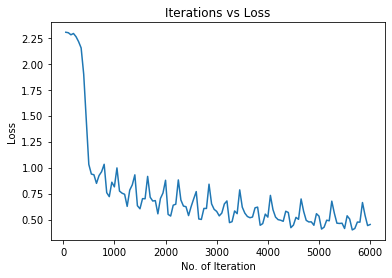

In [17]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

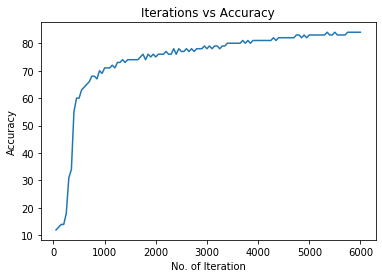

In [18]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [19]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 90.02%
Accuracy of Trouser: 96.18%
Accuracy of Pullover: 70.37%
Accuracy of Dress: 84.35%
Accuracy of Coat: 74.37%
Accuracy of Sandal: 92.93%
Accuracy of Shirt: 51.95%
Accuracy of Sneaker: 92.85%
Accuracy of Bag: 95.70%
Accuracy of Ankle Boot: 96.07%
